In [1]:
from __future__ import annotations
from langchain_core.output_parsers import JsonOutputParser , PydanticOutputParser
import operator
from pathlib import Path
from typing import TypedDict, List, Optional, Literal, Annotated
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
# -----------------------------
# 1) Schemas
# -----------------------------
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="3–6 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(..., description="Target word count for this section (120–550).")

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False


class Plan(BaseModel):
    blog_title: str
    audience: str
    tone: str
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None  # keep if Tavily provides; DO NOT rely on it
    snippet: Optional[str] = None
    source: Optional[str] = None


class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)


class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)

In [3]:
class State(TypedDict):
    topic: str

    # routing / research
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    # workers
    sections: Annotated[List[tuple[int, str]], operator.add]  # (task_id, section_md)
    final: str

In [4]:
structured_llm = ChatOllama(
    model="deepseek-r1:latest",
    format="json",
    temperature=0
)

# LLM for content generation (without JSON mode)
content_llm = ChatOllama(
    model="llama3.2:latest",
    temperature=0.7
)

In [5]:
# -----------------------------
# 3) Router (decide upfront)
# -----------------------------
ROUTER_SYSTEM = """You are a routing module for a technical blog planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 3–10 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""
def router_node(state: State) -> dict:

    parser = PydanticOutputParser(pydantic_object=RouterDecision)

    prompt = ChatPromptTemplate.from_messages([
        ("system", ROUTER_SYSTEM + "\n{format_instructions}"),
        ("human", "{topic}")
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser     # ✅ plain ChatOllama

    decision = chain.invoke({"topic": state["topic"]})

    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
    }

def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"

In [6]:
# -----------------------------
# 4) Research (Tavily) 
# -----------------------------
from dotenv import load_dotenv
load_dotenv()
def _tavily_search(query: str, max_results: int = 5) -> List[dict]:
    
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke({"query": query})

    normalized: List[dict] = []
    for r in results or []:
        normalized.append(
            {
                "title": r.get("title") or "",
                "url": r.get("url") or "",
                "snippet": r.get("content") or r.get("snippet") or "",
                "published_at": r.get("published_date") or r.get("published_at"),
                "source": r.get("source"),
            }
        )
    return normalized


RESEARCH_SYSTEM = """You are a research synthesizer for technical writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
  If missing or unclear, set published_at=null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL.
"""
from langchain_core.output_parsers import PydanticOutputParser

def research_node(state: State) -> dict:

    queries = state.get("queries", []) or []
    max_results = 6

    raw_results: List[dict] = []
    for q in queries:
        raw_results.extend(_tavily_search(q, max_results=max_results))

    if not raw_results:
        return {"evidence": []}

    parser = PydanticOutputParser(pydantic_object=EvidencePack)

    prompt = ChatPromptTemplate.from_messages([
        ("system", RESEARCH_SYSTEM + "\n{format_instructions}"),
        ("human", "Raw Results:\n{raw_results}")
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser     #  plain ChatOllama

    pack = chain.invoke({"raw_results": raw_results})

    # Deduplicate by URL
    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e

    return {"evidence": list(dedup.values())}


In [7]:
# -----------------------------
# 5) Orchestrator (Plan)
# -----------------------------
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
- Create 3-5 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 3–6 bullets that are concrete, specific, and non-overlapping
  3) target word count (120–550)

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
  * minimal code sketch / MWE (set requires_code=True for that section)
  * edge cases / failure modes
  * performance/cost considerations
  * security/privacy considerations (if relevant)
  * debugging/observability tips

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (models/tools/releases) in bullets.
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book:
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.
"""
def orchestrator_node(state: State) -> dict:

    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")

    parser = PydanticOutputParser(pydantic_object=Plan)

    prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "Create a blog plan with 5–7 sections.\n{format_instructions}"
        ),
        (
            "human",
            "Topic: {topic}\n"
            "Mode: {mode}\n\n"
            "Evidence (ONLY use for fresh claims; may be empty):\n"
            "{evidence}"
        )
    ])

    prompt = prompt.partial(
        format_instructions=parser.get_format_instructions()
    )

    chain = prompt | structured_llm | parser   # ✅ plain ChatOllama

    plan = chain.invoke({
        "topic": state["topic"],
        "mode": mode,
        "evidence": [e.model_dump() for e in evidence][:16],
    })

    return {"plan": plan}

In [8]:
# -----------------------------
# 6) Fanout
# -----------------------------
def fanout(state: State):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

In [9]:
# -----------------------------
# 7) Worker (write one section)
# -----------------------------
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker_node(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = content_llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()

    return {"sections": [(task.id, section_md)]}

In [10]:
# -----------------------------
# 8) Reducer (merge + save)
# -----------------------------
def reducer_node(state: State) -> dict:

    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    filename = f"BLOG_{plan.blog_title}.md"
    Path(filename).write_text(final_md, encoding="utf-8")

    return {"final": final_md}

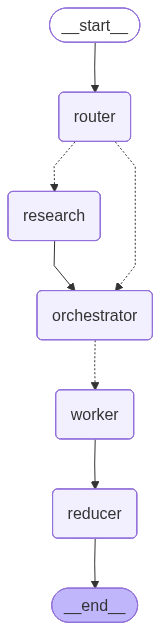

In [11]:
# -----------------------------
# 9) Build graph
# -----------------------------
g = StateGraph(State)
g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator_node)
g.add_node("worker", worker_node)
g.add_node("reducer", reducer_node)

g.add_edge(START, "router")
g.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
g.add_edge("research", "orchestrator")

g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()
app

In [12]:
# -----------------------------
# 10) Runner
# -----------------------------
def run(topic: str):
    out = app.invoke(
        {
            "topic": topic,
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

    return out

In [13]:
response = response = run("Full Working of PyTorch and its Code Example , include diagram is possible")

C:\Users\prana\AppData\Local\Temp\ipykernel_6016\383305728.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=max_results)


OutputParserException: Invalid json output: 隸<think>
Okay, let's start by understanding the user's query. They want a thought process that mirrors how an assistant would approach the problem of explaining PyTorch's main components. The user provided a detailed response, so I need to break down their thinking step by step.

First, the assistant would need to identify the key components of PyTorch mentioned in the response. The main ones are Tensors, Autograd, Neural Network (nn) Module, Optimizers, DataLoader, and Composability. Each of these needs to be explained clearly, with examples to help users grasp how they work together.

The user is likely someone new to PyTorch, maybe a beginner in deep learning. They want a structured understanding of the framework's building blocks. The assistant should consider that the user might not just want definitions but also practical examples of how these components interact in real-world scenarios.

The assistant would think about the user's deeper needs. They probably want to build neural networks efficiently, so explaining how each component contributes to that goal is crucial. For instance, Tensors handle data, Autograd manages gradients, nn.Module structures the network, and DataLoader handles data feeding. Highlighting the synergy between these parts can help the user see the bigger picture.

The assistant should also anticipate common challenges learners face. For example, understanding how Autograd dynamically builds the computation graph or how DataLoader handles data pipelines. Including these aspects can preemptively address potential confusion.

Another consideration is the flow of explanation. Starting with Tensors as the foundation makes sense, then moving to Autograd for computation, followed by nn.Module for structuring models, and so on. This logical progression helps users build concepts step by step.

The assistant might also think about differentiating PyTorch from other frameworks like TensorFlow. Mentioning dynamic computation graphs and Pythonic syntax could highlight PyTorch's advantages for research and rapid prototyping.

Including examples, like the sine wave fitting, makes abstract concepts concrete. The user can relate to seeing how each component is used in code, which aids comprehension.

Finally, the assistant should ensure that the explanation is concise yet thorough, avoiding jargon where possible. Using analogies, like comparing Tensors to NumPy arrays but with GPU support, can make the concepts more accessible.

In summary, the thought process involves identifying key components, understanding user needs, structuring the explanation logically, providing practical examples, and addressing deeper learning objectives to help the user effectively utilize PyTorch for their projects.
</think>
Okay, let's break down the core components of PyTorch that make it a powerful deep learning framework. The response you provided does a great job summarizing them, but let's delve into each one in more detail to understand how they work together.

PyTorch is built around several fundamental concepts:

1.  **Tensors:**
    *   **What they are:** PyTorch's fundamental data structure, similar to NumPy's arrays (n-dimensional arrays). They are the basic building blocks for representing data (like images, text, numerical values) and model parameters (weights, biases).
    *   **Key Features:**
        *   **GPU Acceleration:** Tensors can be moved to a GPU for significantly faster computation, crucial for training large models.
        *   **Automatic Differentiation (Autograd):** Tensors track the operations performed on them. When you perform operations (like matrix multiplication, addition), a computational graph is dynamically built. Crucially, gradients (derivatives) can be automatically computed with respect to these tensors, which is essential for training neural networks using backpropagation.
        *   **Rich API:** PyTorch provides a vast library of functions for tensor operations (math, linear algebra, indexing, reshaping, etc.).

2.  **Autograd (Automatic Differentiation):**
    *   **What it is:** PyTorch's engine for tracking computations and calculating gradients. It's not a separate module you call explicitly for gradients; it's a system that operates automatically on tensors.
    *   **How it works:** When you perform operations on tensors, PyTorch builds a *dynamic computational graph* in the background. Each operation becomes a node in this graph. `autograd` keeps track of this graph and can compute gradients efficiently using backpropagation.
    *   **Why it's important:** It eliminates the need for manual derivation and implementation of gradient calculations, which is a major pain point in deep learning. This allows for rapid experimentation and easier implementation of complex models.

3.  **Neural Network (nn) Module:**
    *   **What it is:** The `torch.nn` module provides building blocks for neural networks. It's a container for layers (called `Modules`) and defines the forward pass (the computation done when data flows through the network).
    *   **Key Features:**
        *   **`nn.Module`:** This is the base class for all neural network architectures in PyTorch. Every custom model should inherit from this class.
        *   **Layers (`nn.Module` subclasses):** These are the basic components (like `nn.Linear`, `nn.Conv2d`, `nn.ReLU`, `nn.LSTM`) that perform specific transformations on the data. The `nn` module provides many standard layers, and you can define your own.
        *   **Parameter Management:** Layers automatically register their learnable parameters (weights and biases) with the parent model. PyTorch knows which parameters to update during training.
        *   **GPU Support:** Parameters and layers can be moved to a GPU automatically if needed.

4.  **Optimizers:**
    *   **What they are:** Optimizers are algorithms that *update* the parameters of your model based on the gradients calculated by Autograd. They implement different update rules (like SGD, Adam, RMSprop) to minimize the loss function.
    *   **How they work:** During training, the optimizer is given the model parameters and the gradients (computed by Autograd). It then uses its specific algorithm to adjust the parameters in a way that reduces the loss.
    *   **Why they are important:** They provide the mechanism for learning – adjusting the model's internal state (weights and biases) based on the error it makes.

5.  **DataLoader:**
    *   **What it is:** Part of the `torch.utils.data` module. It's a tool for efficiently loading data from a dataset into batches for training or evaluation.
    *   **Key Features:**
        *   **Data Sourcing:** Connects to a `Dataset` object (which you define or use from PyTorch's library) that holds your raw data.
        *   **Batching:** Combines individual data points into batches, which is often more efficient for training (and sometimes required by optimizers).
        *   **Shuffling:** Randomly shuffles the data (optionally) to prevent the model from learning patterns based on data order.
        *   **Parallel Loading:** Can use multiple workers (threads/processes) to load data in the background, preventing CPU bottlenecks during training.
        *   **Iteration:** Provides an iterator interface to loop over batches seamlessly.

6.  **Composability:**
    *   **What it means:** This is the overarching principle that all the components (Tensors, Autograd, nn.Modules, Optimizers, DataLoader) are designed to be combined and nested.
    *   **Why it's powerful:** You can build complex models by composing simpler layers (`nn.Module` subclasses). You can define complex data pipelines by combining `DataLoader` with `Dataset` and other transformations. You can even define custom operations and make them learnable by wrapping them in `nn.Module` and adding parameters.

**Putting it Together (Example Flow):**

1.  **Data:** Define a `Dataset` to load your data.
2.  **DataLoader:** Create a `DataLoader` to fetch batches of data from the `Dataset`.
3.  **Model:** Define your neural network model by subclassing `nn.Module` and composing standard layers (`nn.Linear`, `nn.ReLU`, etc.) or custom layers.
4.  **Loss:** Choose a loss function (e.g., `nn.CrossEntropyLoss`).
5.  **Optimizer:** Choose an optimizer (e.g., `optim.SGD` or `optim.Adam`) and pass the model's parameters to it.
6.  **Training Loop:**
    *   For each batch of data from the `DataLoader`:
    *   Perform a forward pass (`model(batch_data)`) to get the output (involves `nn.Module`'s `forward` method).
    *   Calculate the loss between the output and the target (using the loss function).
    *   Perform a backward pass (`loss.backward()`) – Autograd calculates gradients for all parameters involved in the computation.
    *   The optimizer updates the model's parameters (`optimizer.step()`) using the calculated gradients.
    *   (Optional) Reset gradients (`optimizer.zero_grad()`) before the next iteration.

These components work together seamlessly, allowing you to focus on designing your model architecture and defining your training procedure, while PyTorch handles the underlying computational details (tensor operations, gradients, optimization, data handling).
For troubleshooting, visit: https://docs.langchain.com/oss/python/langchain/errors/OUTPUT_PARSING_FAILURE 